In [1]:
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt

from spring_rods_system_setup import SpringRodsSystemSetup
from spring_rods_system_with_penalization_setup import SpringRodSystemWithPenalizationSetup
from spring_rods_system_solver import SpringRodsSystemSolver
from utils.computational_utils import l2_norm

In [2]:
model_setup = {
    'interval': (-1, 1),
    'spring_len': 1,
    'step_size': 1/16,
    'material_const': (1, 1),
    'spring_const': (1, 1),
    'body_forces': lambda x: np.where(x < 1, -1, 0),
}

In [3]:
model = SpringRodsSystemSetup(**model_setup)
solver = SpringRodsSystemSolver(model)
real_solution = solver()

In [4]:
def penal_func(x: Tuple[np.ndarray, np.ndarray]):
    spring_len = model_setup['spring_len']
    theta = spring_len - x[0][-1] + x[1][0]
    # This is specific for looking for a solution with assumption of spring compression
    if theta < spring_len:
        return 0
    return (spring_len - theta)**2

# def penal_func(x: Tuple[np.ndarray, np.ndarray]):
#     return (x[0][-1] - x[1][0])**2

In [5]:
penalized_model = SpringRodSystemWithPenalizationSetup(
    **model_setup,
    penalization_function=penal_func,
    penalization_const=1 # this is going to be overwritten
)
solver = SpringRodsSystemSolver(penalized_model)

In [6]:
# penal_params = np.array([1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7])
penal_params = np.array([1 / (1 << x) for x in range(10, 20)])

In [7]:
print(penal_params)

[9.76562500e-04 4.88281250e-04 2.44140625e-04 1.22070312e-04
 6.10351562e-05 3.05175781e-05 1.52587891e-05 7.62939453e-06
 3.81469727e-06 1.90734863e-06]


In [8]:
cmap = plt.get_cmap('viridis', penal_params.size)

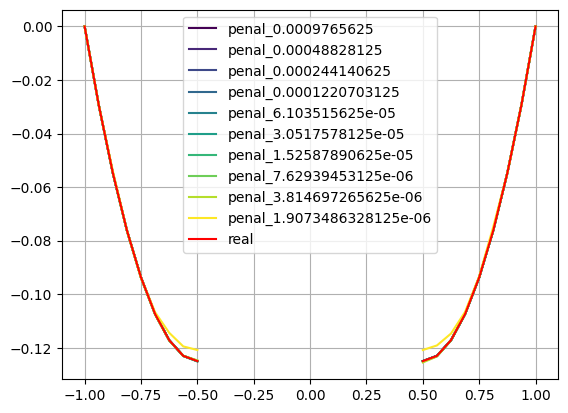

In [9]:
error_norm = []

for idx, val in enumerate(penal_params):
    penalized_model.penalization_const = val
    solution = solver()

    err = tuple(solution[side] - real_solution[side] for side in (0, 1))
    error_norm.append(l2_norm(values=err, domain=model.domain))

    plt.plot(penalized_model.domain[0], solution[0], color=cmap(idx), label=f'penal_{val}')
    plt.plot(penalized_model.domain[1], solution[1], color=cmap(idx))

plt.plot(model.domain[0], real_solution[0], color='red', label='real')
plt.plot(model.domain[1], real_solution[1], color='red')

plt.legend()
plt.grid()

([<matplotlib.axis.YTick at 0x7f03b8bd9040>,
 [Text(0, 5.945798747094893e-08, '5.95e-08'),
  Text(0, 1.1888315941446625e-07, '1.19e-07'),
  Text(0, 2.3775123598967756e-07, '2.38e-07'),
  Text(0, 4.754133861291428e-07, '4.75e-07'),
  Text(0, 9.505626816149909e-07, '9.51e-07'),
  Text(0, 1.3985994869184606e-06, '1.40e-06'),
  Text(0, 5.881525943003176e-06, '5.88e-06'),
  Text(0, 6.142558218785755e-06, '6.14e-06'),
  Text(0, 2.2910851812714683e-05, '2.29e-05'),
  Text(0, 0.00013978537355262722, '1.40e-04')])

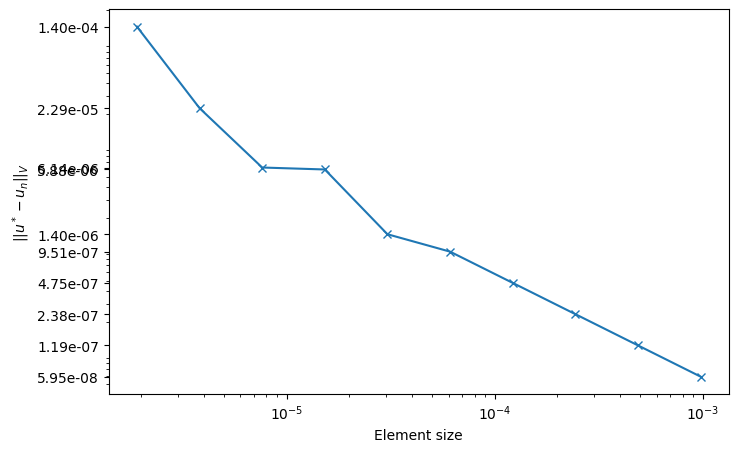

In [10]:
fig = plt.gcf()
fig.set_size_inches(8, 5)

plt.plot(penal_params, error_norm, marker='x')
plt.xlabel('Element size')
plt.ylabel('$||u^* - u_n||_V$')
plt.xscale('log')
plt.yscale('log')
# plt.xticks(penal_params, [f'${{{q}}}^{{-1}}$' for q in penal_params])
plt.yticks(error_norm, [f'{err:.2e}' for err in error_norm])